In [4]:
# import librairies and functions needed for project

# utilities
import os, warnings
os.environ["OMP_NUM_THREADS"] = '1'  # needed to avoid memory leak warning with K-Means in Windows environment
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)  # ignore all future warnings

# data
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)  # maximise dataframe display

# modelisation
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})

# Définir la couleur bleue
col = "blue"

# import user-defined functions
from functions import *

<span style="font-size:24px; font-weight:bold;">1 - Importation des données</span>

In [5]:
# Import data
x_train = pd.read_csv('x_train.csv', encoding='latin_1')
print(x_train.shape)
x_train.head()

(1200, 6)


diagonal  height_left  height_right  margin_low  margin_up  length
0    172.28       104.62        103.80        4.08       3.08  113.26
1    171.90       104.50        103.49        4.08       2.82  113.50
2    171.63       104.33        104.61        4.88       3.35  112.16
3    172.06       104.28        104.31        5.61       3.27  111.61
4    172.10       104.42        103.60        4.18       2.89  113.32

In [6]:
# Import data
x_test = pd.read_csv('x_test.csv', encoding='latin_1')
print(x_test.shape)
x_test.head()

(300, 6)


diagonal  height_left  height_right  margin_low  margin_up  length
0    172.26       103.90        104.12    4.990000       3.42  111.27
1    171.65       104.32        104.38    5.650000       3.24  112.30
2    171.53       103.53        103.63    4.040000       2.96  112.76
3    172.30       103.66        103.50    4.160539       3.16  112.95
4    172.17       103.79        103.54    4.070000       2.78  113.03

In [7]:
y_train = pd.read_csv('y_train.csv', encoding='latin_1')
print(y_train.shape)
y_train.head()

(1200, 1)


is_genuine
0        True
1        True
2       False
3       False
4        True

In [8]:
y_test = pd.read_csv('y_test.csv', encoding='latin_1')
print(y_test.shape)
y_test.head()

(300, 1)


is_genuine
0       False
1       False
2        True
3        True
4        True

In [9]:
# check for missing values
if (((x_train.loc[x_train.isna().any(axis=1) == True].shape[0]) != 0)
    | ((y_train.loc[y_train.isna().any(axis=1) == True].shape[0]) != 0)
    | ((x_test.loc[x_test.isna().any(axis=1) == True].shape[0]) != 0)
    | ((y_test.loc[y_test.isna().any(axis=1) == True].shape[0]) != 0)
   ):
    print("!!! Valeurs manquantes !!!")
else:
    print ("Pas de valeurs manquantes dans les tables.")
    
# check for missing data
if (((x_train.loc[x_train.isnull().any(axis=1) == True].shape[0]) != 0)
    | ((y_train.loc[y_train.isnull().any(axis=1) == True].shape[0]) != 0)
    | ((x_test.loc[x_test.isnull().any(axis=1) == True].shape[0]) != 0)
    | ((y_test.loc[y_test.isnull().any(axis=1) == True].shape[0]) != 0)   
   ):
    print("!!! Valeurs nulles !!! ")
else:
    print ("Pas de valeurs nulles dans les tables.")
    
# check for duplicates
if (((x_train.loc[x_train.duplicated() == True].shape[0]) != 0)
    | ((x_test.loc[x_test.duplicated() == True].shape[0]) != 0)
   ):
    print("!!! Doublons dans les tables !!!")
else:
    print ("Pas de doublons dans les tables.")

Pas de valeurs manquantes dans les tables.
Pas de valeurs nulles dans les tables.
Pas de doublons dans les tables.


In [10]:
# rename column
y_train = y_train.rename(columns={"is_genuine":"target"})
y_train.head()

target
0    True
1    True
2   False
3   False
4    True

In [11]:
# rename column
y_test = y_test.rename(columns={"is_genuine":"target"})
y_test.head()

target
0   False
1   False
2    True
3    True
4    True

<span style="font-size:24px; font-weight:bold;">2 - Caratéristiques du modèle</span>

HASHTAG SECTIONS below to run regression & optimisation on full dataset (else significant variables only will be used)

In [12]:
Y = y_train.values.ravel()
X = x_train.copy()
X = sm.add_constant(X, prepend=True, has_constant='skip')
reg_log_1 = sm.GLM(endog=Y, exog=X, family=sm.families.Binomial()).fit()
print(reg_log_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1200
Model:                            GLM   Df Residuals:                     1193
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36.650
Date:                Thu, 14 Nov 2024   Deviance:                       73.299
Time:                        19:06:49   Pearson chi2:                 1.96e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6988
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -81.6224    257.021     -0.318   

La p-value des variables diagonal et height_left est tres superieure a 5%, donc ces variables ne sont pas significatives pour la regression logistique. Nous procedons par elimination en retirant en premier lieu diagonal dont la p_value est la plus elevee.

In [13]:
X_2 = x_train.drop(columns='diagonal').copy()
X_2 = sm.add_constant(X_2, prepend=True, has_constant='skip')
reg_log_2 = sm.GLM(endog=Y, exog=X_2, family=sm.families.Binomial()).fit()
print(reg_log_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1200
Model:                            GLM   Df Residuals:                     1194
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36.713
Date:                Thu, 14 Nov 2024   Deviance:                       73.426
Time:                        19:06:49   Pearson chi2:                 1.89e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6988
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -148.9974    174.810     -0.852   

La p-value de la variable height_left est toujours supérieure à 5%, donc nous retirons également cette variable de l'analyse.

In [14]:
X_3 = x_train.drop(columns={'diagonal', 'height_left'}).copy()
X_3 = sm.add_constant(X_3, prepend=True, has_constant='skip')
reg_log_3 = sm.GLM(endog=Y, exog=X_3, family=sm.families.Binomial()).fit()
print(reg_log_3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1200
Model:                            GLM   Df Residuals:                     1195
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -37.803
Date:                Thu, 14 Nov 2024   Deviance:                       75.605
Time:                        19:06:49   Pearson chi2:                 2.45e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6983
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -296.0525    152.148     -1.946   

Toutes nos variables ont a present des p-values inferieures a 5%.

In [15]:
x_train.drop(columns={'diagonal', 'height_left'}, inplace=True, errors='raise')
print(x_train.shape)
x_train.head()

(1200, 4)


height_right  margin_low  margin_up  length
0        103.80        4.08       3.08  113.26
1        103.49        4.08       2.82  113.50
2        104.61        4.88       3.35  112.16
3        104.31        5.61       3.27  111.61
4        103.60        4.18       2.89  113.32

In [16]:
x_test.drop(columns={'diagonal', 'height_left'}, inplace=True, errors='raise')
print(x_test.shape)
x_test.head()

(300, 4)


height_right  margin_low  margin_up  length
0        104.12    4.990000       3.42  111.27
1        104.38    5.650000       3.24  112.30
2        103.63    4.040000       2.96  112.76
3        103.50    4.160539       3.16  112.95
4        103.54    4.070000       2.78  113.03

END HASHTAG SECTIONS

In [17]:
# center & reduce data
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(x_train)
x_test_scaled = std_scaler.transform(x_test)

<span style="font-size:14px; font-weight:bold;">La regression logistique est implementee dans scikit-learn : sklearn.linear_model.LogisticRegression. Regularisation :  on peut utiliser la regularisation pour controler les coefficients d'une regression lineaire, et eviter le sur-apprentissage ou creer des modeles parcimonieux. Les memes concepts s'appliquent a la regression logistique, a la difference que la regression logistique regularisee par la norme ℓ2 n'admet pas de solution explicite. On pourra donc utiliser la regression logistique avec regularisation  ℓ2 pour eviter le sur-apprentissage (dans scikit-learn, c'est meme l'implémentation par defaut de la regression logistique) ou la regression logistique avec regularisation ℓ1 pour obtenir un modele parcimonieux (dans scikit-learn, il suffit d'utiliser l'option 'penalty'=l1).</span>

<span style="font-size:24px; font-weight:bold;">3 - Regression logistique avec Scikit-Learn</span> 

In [18]:
# initialize regression
estimator = LogisticRegression(solver="liblinear", random_state=42)
estimator.fit(x_train_scaled, y_train.values.ravel())

# predict results
y_pred = estimator.predict(x_test_scaled)
y_prob = estimator.predict_proba(x_test_scaled).round(2)

In [19]:
# compute and print R2 on training and testing sets
def score(estimator):
    tr_score = estimator.score(x_train_scaled, y_train.values.ravel()).round(4)
    te_score = estimator.score(x_test_scaled, y_test.values.ravel()).round(4)
    print(f"R2 train: {tr_score} R2 test: {te_score}")

In [20]:
def score(estimator):
    # Calcul du score d'entraînement
    tr_score = estimator.score(x_train_scaled, y_train)
    tr_score = round(tr_score, 4)  # Arrondir à 4 décimales
    print(f"R2 train: {tr_score}")

    # Calcul du score de test
    te_score = estimator.score(x_test_scaled, y_test)
    te_score = round(te_score, 4)  # Arrondir à 4 décimales
    print(f"R2 test: {te_score}")

In [21]:
# calculate precision score ie the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false
# positives => measures the ability of the classifier not to label as positive a sample that is negative (190/193 here)
print("Precision score:", round(precision_score(y_test.values.ravel(), y_pred),4))  # (190/193 here)

Precision score: 0.9845


In [22]:
# calculate recall score ie the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false
# negatives => measures the ability of the classifier to find all the positive samples
print("Recall score:", round(recall_score(y_test.values.ravel(), y_pred),4))  # (190/190 here)

Recall score: 1.0


In [23]:
estimator.intercept_

array([1.89596005])

In [24]:
print("Coefficients: \n", estimator.coef_)

Coefficients: 
 [[-0.79290794 -2.59286167 -1.50997192  3.57526725]]


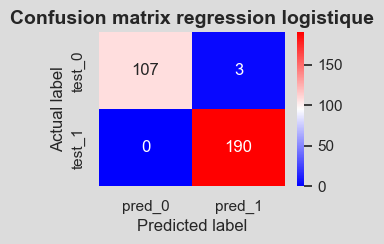

In [25]:
# heatmap of confusion matrix
conf_reglog = confusion(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(pd.DataFrame(conf_reglog), annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix regression logistique', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig("conf_matrix_reglog_init.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

<span style="font-size:14px; font-weight:bold;">La regression logistique sans optimisation des hyper-parametres donne un taux de faux negatifs de zero (0/190) mais un taux de faux positifs de 2.73% (3/110). Nous allons donc essayer d'optimiser les hyper-parametres afin de faire diminuer ce taux sans compromettre le taux de faux negatifs dans la mesure du possible (il s'agit en effet d'une erreur "moins grave" sur laquelle une tolerance peut etre admise).</span> 

<span style="font-size:24px; font-weight:bold;">4 - Optimisation de la regression logistique avec GridSearchCV</span> 

The choice of the algorithm depends on the penalty chosen. Supported penalties by solver:

‘lbfgs’ - [‘l2’, None]

‘liblinear’ - [‘l1’, ‘l2’]

‘newton-cg’ - [‘l2’, None]

‘newton-cholesky’ - [‘l2’, None]

‘sag’ - [‘l2’, None]

‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]

Note ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Nous etablissons donc 3 groupes d'hyper-parametres pour tester le modele avec les differents algorithmes de regression logistique offerts par Scikit-Learn, tous les solveurs n'acceptant pas les memes penalites en entree.

In [26]:
estimator = LogisticRegression()

# newton-cg, lbfgs and sag solvers
params_nsag = {'C':np.logspace(-3, 3, 7),
              'penalty':['l2', 'none'],
              'solver':['newton-cg', 'lbfgs', 'sag'],
              'random_state':[42],
              'class_weight':[None, 'balanced'],
               'max_iter':[500]
              }

# liblin solver
params_liblin = {'C':np.logspace(-3, 3, 7),
                'penalty':['l1', 'l2'],
                'solver':['liblinear'],
                'random_state':[42],
                'class_weight':[None, 'balanced'],
                'max_iter': [500]
                }

# saga solver
params_saga = {'C':np.logspace(-3,3,7),
              'penalty':['l1','l2','elasticnet', 'none'],
              'solver':['saga'],
              'random_state':[42],
              'class_weight':[None, 'balanced'],
              'max_iter':[500],
              "l1_ratio":[0,0.25,0.5,0.75,1]
              }

<span style="font-size:14px; font-weight:bold;">4.1) Solveurs newton-cg, lbfgs et sag</span> 

In [27]:
grid_nsag = GridSearchCV(estimator,
                         params_nsag,
                         cv=10,
                         n_jobs=-1,
                         return_train_score=True,
                         verbose=0)
grid_nsag.fit(x_train_scaled, y_train.values.ravel())

# see dox here
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

C:\Users\jemko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
420 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
57 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jemko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jemko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\jemko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'class_weight': [None, 'balanced'], 'max_iter': [500],
                         'penalty': ['l2', 'none'], 'random_state': [42],
                         'solver': ['newton-cg', 'lbfgs', 'sag']},
             return_train_score=True)

In [28]:
best_params_nsag = grid_nsag.best_params_
best_params_nsag

{'C': 10.0,
 'class_weight': None,
 'max_iter': 500,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'newton-cg'}

In [29]:
estimator_nsag = LogisticRegression(**best_params_nsag)
estimator_nsag.fit(x_test_scaled, y_test.values.ravel())
y_pred_nsag = estimator_nsag.predict(x_test_scaled)

In [30]:
score(estimator_nsag)

R2 train: 0.9908
R2 test: 1.0


In [31]:
# calculate precision score 
print("Precision score:", round(precision_score(y_test.values.ravel(), y_pred_nsag),4))  # (190/190 here)

Precision score: 1.0


In [32]:
# calculate recall score
print("Recall score:", round(recall_score(y_test.values.ravel(), y_pred_nsag),4))  # (190/190 here)

Recall score: 1.0


In [33]:
print("Intercept: \n", *estimator_nsag.intercept_)

Intercept: 
 2.3203373377711696


In [34]:
print("Coefficients: \n", *estimator_nsag.coef_)

Coefficients: 
 [-0.62731659 -4.52896825 -2.9102929   5.24782958]


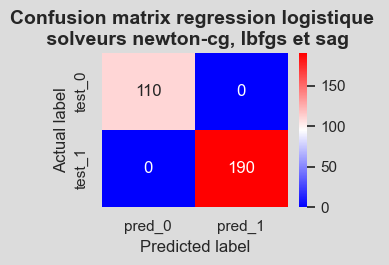

In [35]:
# heatmap of confusion matrix
conf_nsag = confusion(y_test.values.ravel(), y_pred_nsag)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(pd.DataFrame(conf_nsag), annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix regression logistique \n solveurs newton-cg, lbfgs et sag', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig("conf_matrix_nsag.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

<span style="font-size:14px; font-weight:bold;">4.2) Solveur liblin </span> 

In [36]:
grid_liblin = GridSearchCV(estimator,
                           params_liblin,
                           cv=10,
                           n_jobs=-1,
                           return_train_score=True,
                           verbose=0)
grid_liblin.fit(x_train_scaled, y_train.values.ravel())

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'class_weight': [None, 'balanced'], 'max_iter': [500],
                         'penalty': ['l1', 'l2'], 'random_state': [42],
                         'solver': ['liblinear']},
             return_train_score=True)

In [37]:
best_params_liblin = grid_liblin.best_params_
best_params_liblin

{'C': 0.1,
 'class_weight': None,
 'max_iter': 500,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear'}

In [38]:
estimator_liblin = LogisticRegression(**best_params_liblin)
estimator_liblin.fit(x_test_scaled, y_test.values.ravel())
y_pred_liblin = estimator_liblin.predict(x_test_scaled)

In [39]:
score(estimator_liblin)

R2 train: 0.9908
R2 test: 0.9967


In [40]:
# calculate precision score
print("Precision score:", round(precision_score(y_test.values.ravel(), y_pred_liblin),4))  # (190/191 here)

Precision score: 0.9948


In [41]:
# calculate recall score
print("Recall score:", round(recall_score(y_test.values.ravel(), y_pred_liblin),4))  # (190/190 here)

Recall score: 1.0


In [42]:
print("Intercept: \n", *estimator_liblin.intercept_)

Intercept: 
 0.6208147593219466


In [43]:
print("Coefficients: \n", *estimator_liblin.coef_)

Coefficients: 
 [-0.08141933 -1.48322109 -0.48407812  1.84395348]


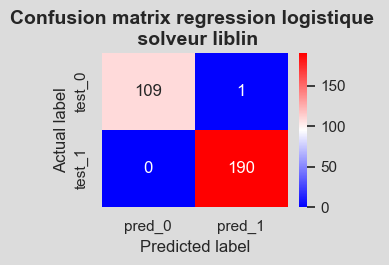

In [44]:
# heatmap of confusion matrix
conf_liblin = confusion(y_test.values.ravel(), y_pred_liblin)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(pd.DataFrame(conf_liblin), annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix regression logistique \n solveur liblin', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig("conf_matrix_liblin.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

<span style="font-size:14px; font-weight:bold;">4.3) Solveur saga </span> 

In [45]:
grid_saga = GridSearchCV(estimator,
                         params_saga,
                         cv=10,
                         n_jobs=-1,
                         return_train_score=True,
                         verbose=0)
grid_saga.fit(x_train_scaled, y_train.values.ravel())

C:\Users\jemko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
700 fits failed out of a total of 2800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
176 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jemko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jemko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\jemko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\bas

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'class_weight': [None, 'balanced'],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1], 'max_iter': [500],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'random_state': [42], 'solver': ['saga']},
             return_train_score=True)

In [46]:
best_params_saga = grid_saga.best_params_
best_params_saga

{'C': 0.01,
 'class_weight': 'balanced',
 'l1_ratio': 0.75,
 'max_iter': 500,
 'penalty': 'elasticnet',
 'random_state': 42,
 'solver': 'saga'}

In [47]:
estimator_saga = LogisticRegression(**best_params_saga)
estimator_saga.fit(x_test_scaled, y_test.values.ravel())
y_pred_saga = estimator_saga.predict(x_test_scaled)

In [48]:
score(estimator_saga)

R2 train: 0.9817
R2 test: 0.9833


In [49]:
# calculate precision score
print("Precision score:", round(precision_score(y_test.values.ravel(), y_pred_saga),4))  # (190/190 here)

Precision score: 0.9744


In [50]:
# calculate recall score
print("Recall score:", round(recall_score(y_test.values.ravel(), y_pred_saga),4))  # (190/190 here)

Recall score: 1.0


In [51]:
print("Intercept: \n", *estimator_saga.intercept_)

Intercept: 
 0.18968745667302175


In [52]:
print("Coefficients: \n", *estimator_saga.coef_)

Coefficients: 
 [ 0.         -0.31338784  0.          0.35055731]


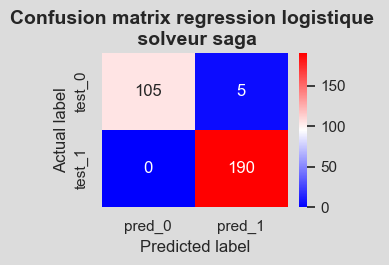

In [53]:
# heatmap of confusion matrix
conf_saga = confusion(y_test.values.ravel(), y_pred_saga)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(pd.DataFrame(conf_saga), annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix regression logistique \n solveur saga', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig("conf_matrix_saga.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

Les meilleurs modèles sont donc les solveurs Newton-cg, parcequ'il minimisent  la fois les faux positifs (i.e. faux billets identifies comme vrais, ici 0 / 110) et les faux negatifs (vrais billets identifies comme faux, ici 0 / 190). Cependant je vais appliquer le modèle saga en application des recommandations de la documentation de scikit-learn et en raison d'une efficacite computationelle plus grande que celle de l'algorithme newton-cg (convergence plus rapide sur des données centrées-reduites).

<span style="font-size:24px; font-weight:bold;">5 - Regression Logistique finale </span> 

In [54]:
estimator_final = LogisticRegression(**best_params_saga)
estimator_final.fit(x_train_scaled, y_train.values.ravel())
y_pred_final = estimator_final.predict(x_test_scaled)

In [55]:
score(estimator_final)

R2 train: 0.9917
R2 test: 0.99


In [56]:
# calculate precision score
print("Precision score:", round(precision_score(y_test.values.ravel(), y_pred_final),4))  # (190/194 here)

Precision score: 0.9845


In [57]:
# calculate recall score
print("Recall score:", round(recall_score(y_test.values.ravel(), y_pred_final),4))  # (190/190 here)

Recall score: 1.0


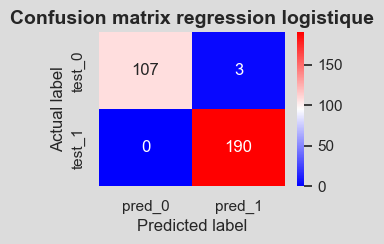

In [58]:
# heatmap of confusion matrix
conf_final = confusion(y_test.values.ravel(), y_pred_final)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(pd.DataFrame(conf_final), annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix regression logistique', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig("conf_matrix_final.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [59]:
print("Coefficients: \n", *estimator_final.coef_)

Coefficients: 
 [-0.11322817 -0.80594374 -0.37333865  1.19561361]


In [60]:
print("Intercept: \n", *estimator_final.intercept_)

Intercept: 
 0.6068828475407314


In [61]:
# Import data
data_prod = pd.read_csv('billets_production.csv', encoding='latin_1')

# check for missing values
if (data_prod.loc[data_prod.isna().any(axis=1) == True].shape[0]) != 0:
    print("!!! Valeurs manquantes !!!")
else:
    print ("Pas de valeurs manquantes.")
# check for missing data
if (data_prod.loc[data_prod.isnull().any(axis=1) == True].shape[0]) != 0:
    print("!!! Valeurs nulles !!! ")
else:
    print ("Pas de valeurs nulles.")
# check for duplicates
if (data_prod.loc[data_prod.duplicated() == True].shape[0]) != 0:
    print("!!! Doublons dans la table !!!")
else:
    print ("Pas de doublons dans la table.")

Pas de valeurs manquantes.
Pas de valeurs nulles.
Pas de doublons dans la table.


In [62]:
# split file

# use if running model with all variables
# X = data_prod[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

# use if running model with significant variables only
X = data_prod[['height_right', 'margin_low', 'margin_up', 'length']]

X_scaled = std_scaler.transform(X)
banknotes_prod = data_prod['id']
X

height_right  margin_low  margin_up  length
0        103.54        5.21       3.30  111.42
1        104.13        6.00       3.31  112.09
2        104.29        4.99       3.39  111.57
3        104.34        4.44       3.03  113.20
4        103.56        3.77       3.16  113.33

In [65]:
# Ajout de la colonne de probabilités
data_prod['proba'] = estimator_final.predict_proba(X_scaled)[:, 1]

# Prédiction des étiquettes basées sur les probabilités
data_prod['labels_pred_reglog'] = data_prod['proba'] > 0.5

# predict banknote type
data_prod['proba'] = estimator_final.predict_proba(X_scaled)[:, 1]
data_prod.loc[data_prod['proba'] > 0.5, 'labels_pred_reglog'] = True
data_prod.loc[data_prod['proba'] <= 0.5, 'labels_pred_reglog'] = False
data_prod.to_csv('data_prod.csv', index=False, encoding='latin_1')
data_prod

diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

      proba  labels_pred_reglog  
0  0.106014               False  
1  0.082476               False  
2  0.112658               False  
3  0.800609                True  
4  0.920484                True

In [68]:
print("Resultats:\n")
for k, l, p in zip(data_prod["labels_pred_reglog"], data_prod["id"], data_prod["proba"]):
    if k:
        print(f"Le billet ref. {l} est un vrai billet avec une probabilité de {p * 100:.2f} %.")
    else:
        print(f"Le billet ref. {l} est un faux billet avec une probabilité de {p * 100:.2f} %.")

Resultats:

Le billet ref. A_1 est un faux billet avec une probabilité de 10.60 %.
Le billet ref. A_2 est un faux billet avec une probabilité de 8.25 %.
Le billet ref. A_3 est un faux billet avec une probabilité de 11.27 %.
Le billet ref. A_4 est un vrai billet avec une probabilité de 80.06 %.
Le billet ref. A_5 est un vrai billet avec une probabilité de 92.05 %.
